In [1]:
# Loading the required libraries
import nltk
import math
import json
import string
import tweepy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import pyLDAvis.sklearn
from itertools import chain
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Setting the size of plots generated.
sns.set(rc={'figure.figsize':(17,8)})

/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


Below code is used for fetching the tweets and as the files are already saved have commented the code

In [52]:
# Function for initialing the twitter API client
def twitterClient():
    """
        Setup Twitter API client.

        @returns: tweepy.API object
    """

    bearerToken = ""
    client = tweepy.Client(bearerToken)

    return client
client = twitterClient()

In [75]:


# Fields to be retrieved
# response_fields = ['created_at',"entities", "text", "lang", "public_metrics", 'geo', 'author_id']

# # Initialising the twitter client
# client = twitterClient()

# # # Using paginator retrieving all the required tweets. We will be receiving all the tweets from the last 7 days
# # # tweets = tweepy.Paginator(client.get_users_tweets, id=client.get_user(username="trussliz").data.id, max_results=100).flatten()
# tweets = tweepy.Paginator(client.search_recent_tweets, query='"#UK" "energy" "policy"', tweet_fields = response_fields, max_results=100).flatten()

# # # Converting the tweets to a list object
# # tweets = list(tweets)

# tweets_dict_list = []

# # # Mapping the data retrieved into a list of dictionaries.
# for tweet in tweets:
#     tweet_obj = {
#         "id": tweet['id'],
#         "text": tweet.get("text"),
#         "time": str(tweet.get("created_at")),
#         "hastags": [hastag['tag'].lower() for hastag in tweet.get("entities").get("hashtags")] if tweet.get("entities") and tweet.get("entities").get("hashtags") else None,
#         "mentions": [mention['username'].lower() for mention in tweet.get("entities").get("mentions")] if tweet.get("entities") and tweet.get("entities").get("mentions") else None,
#         "language": tweet.get("lang").strip(),
#         "retweet count": tweet.get("public_metrics").get("retweet_count"),
#         "like_count": tweet.get("public_metrics").get("like_count"),
#         "country": tweet.get('geo') if tweet.get('geo') else None,
#         "author": tweet.get('author_id')
#     }
#     tweets_dict_list.append(tweet_obj)
    
# # # # # Creation of the object to be written to the file
# tweets_data_as_dict = {'data': tweets_dict_list}
    
# # # # # Dumping the json data to the file
# with open("COSC2671-assign1-energy_policy.json", 'w', encoding="utf-8") as data:
#     json.dump(tweets_data_as_dict, data, indent = 6)

# tweets_dict_list

In [76]:
# response_fields = ['created_at',"entities", "text", "lang", "public_metrics", 'geo']

# # Initialising the twitter client
# client = twitterClient()
# tweets = tweepy.Paginator(client.search_recent_tweets, query='"#UK" "energy" "policy"', tweet_fields = response_fields, max_results=100).flatten(limit=100)

In [5]:
# client = twitterClient()
# # name of ego (yourself)
sEgoId = client.get_user(username="trussliz").data.id
sEgoName = client.get_user(username="trussliz").data.username
# # maximum number of results
maxResults = 300

In [6]:
# user fields to retrieve (modify if want other fields to retrieve)
# lUserFields = ["id","name","public_metrics"]
# # twitterResponse = client.get_users_followers(id=sEgoId, max_results=1000, pagination_token=None, tweet_fields=None, user_fields=lUserFields, user_auth=False)

# twitterResponse = tweepy.Paginator(client.get_users_followers, id=sEgoId, max_results=1000, pagination_token=None, tweet_fields=None, user_fields=lUserFields, user_auth=False).flatten(limit=1000)

In [7]:
client = twitterClient()

In [8]:
# TODO: Remember to import networkx
# ANSWER



# TODO: Construct initial graph object
# construct directed graph
egoGraph = nx.DiGraph()



# user fields to retrieve (modify if want other fields to retrieve)
lUserFields = ["id","name","public_metrics"]

#
# Retrive followers of the ego
#
twitterResponse = client.get_users_followers(id=sEgoId, max_results=maxResults, pagination_token=None, tweet_fields=None, user_fields=lUserFields, user_auth=False)
# loop through the results from first page
for user in twitterResponse.data:
    sFollowerName = user.username
    
    # ANSWER: adding nodes and edges
    # add follower to graph
    # first add node then add the edge
    egoGraph.add_node(sFollowerName, followerCount=user.public_metrics["followers_count"])

    egoGraph.add_edge(sFollowerName, sEgoName)
    
    
# keep looping through each page of results until there are none left (AttributeError will be thrown)
while True:
    try:
        twitterResponse = client.get_users_followers(id=sEgoId, max_results=300, pagination_token=twitterResponse.next_token, tweet_fields=None, user_fields=lUserFields, user_auth=False)
    except AttributeError:
        break
        
    # process each subsequent page of followers
    for user in twitterResponse.data:
        sFollowerName = user.username
        
        # ANSWER: adding nodes and edges
        # add follower to graph
        # first add node then add the edge
        egoGraph.add_node(sFollowerName, followerCount=user.public_metrics["followers_count"])

        egoGraph.add_edge(sFollowerName, sEgoName)




In [9]:
# user fields to retrieve (modify if want other fields to retrieve)
lUserFields = ["id","name","public_metrics"]

#
# Retrive followed (people who follows the ego user)
#
twitterResponse = client.get_users_following(id=sEgoId, max_results=maxResults, pagination_token=None, tweet_fields=None, user_fields=lUserFields, user_auth=False)
# loop through the results from first page
for user in twitterResponse.data:
    sFollowedName = user.username

    # ANSWER: adding nodes and edges
    # add follower to graph
    # first add node then add the edge
    egoGraph.add_node(sFollowedName, followerCount=user.public_metrics["followers_count"])

    egoGraph.add_edge(sEgoName, sFollowedName)
    
    

# keep looping through each page of results until there are none left (AttributeError will be thrown)
while True:
    try:
        twitterResponse = client.get_users_following(id=sEgoId, max_results=maxResults, pagination_token=twitterResponse.next_token, tweet_fields=None, user_fields=lUserFields, user_auth=False)
    except AttributeError:
        break
        
    # process each page of followers
    for user in twitterResponse.data:
        sFollowedName = user.username
        
        # ANSWER: adding nodes and edges
        # add follower to graph
        # first add node then add the edge
        egoGraph.add_node(sFollowedName, followerCount=user.public_metrics["followers_count"])

        egoGraph.add_edge(sEgoName, sFollowedName)
        
        

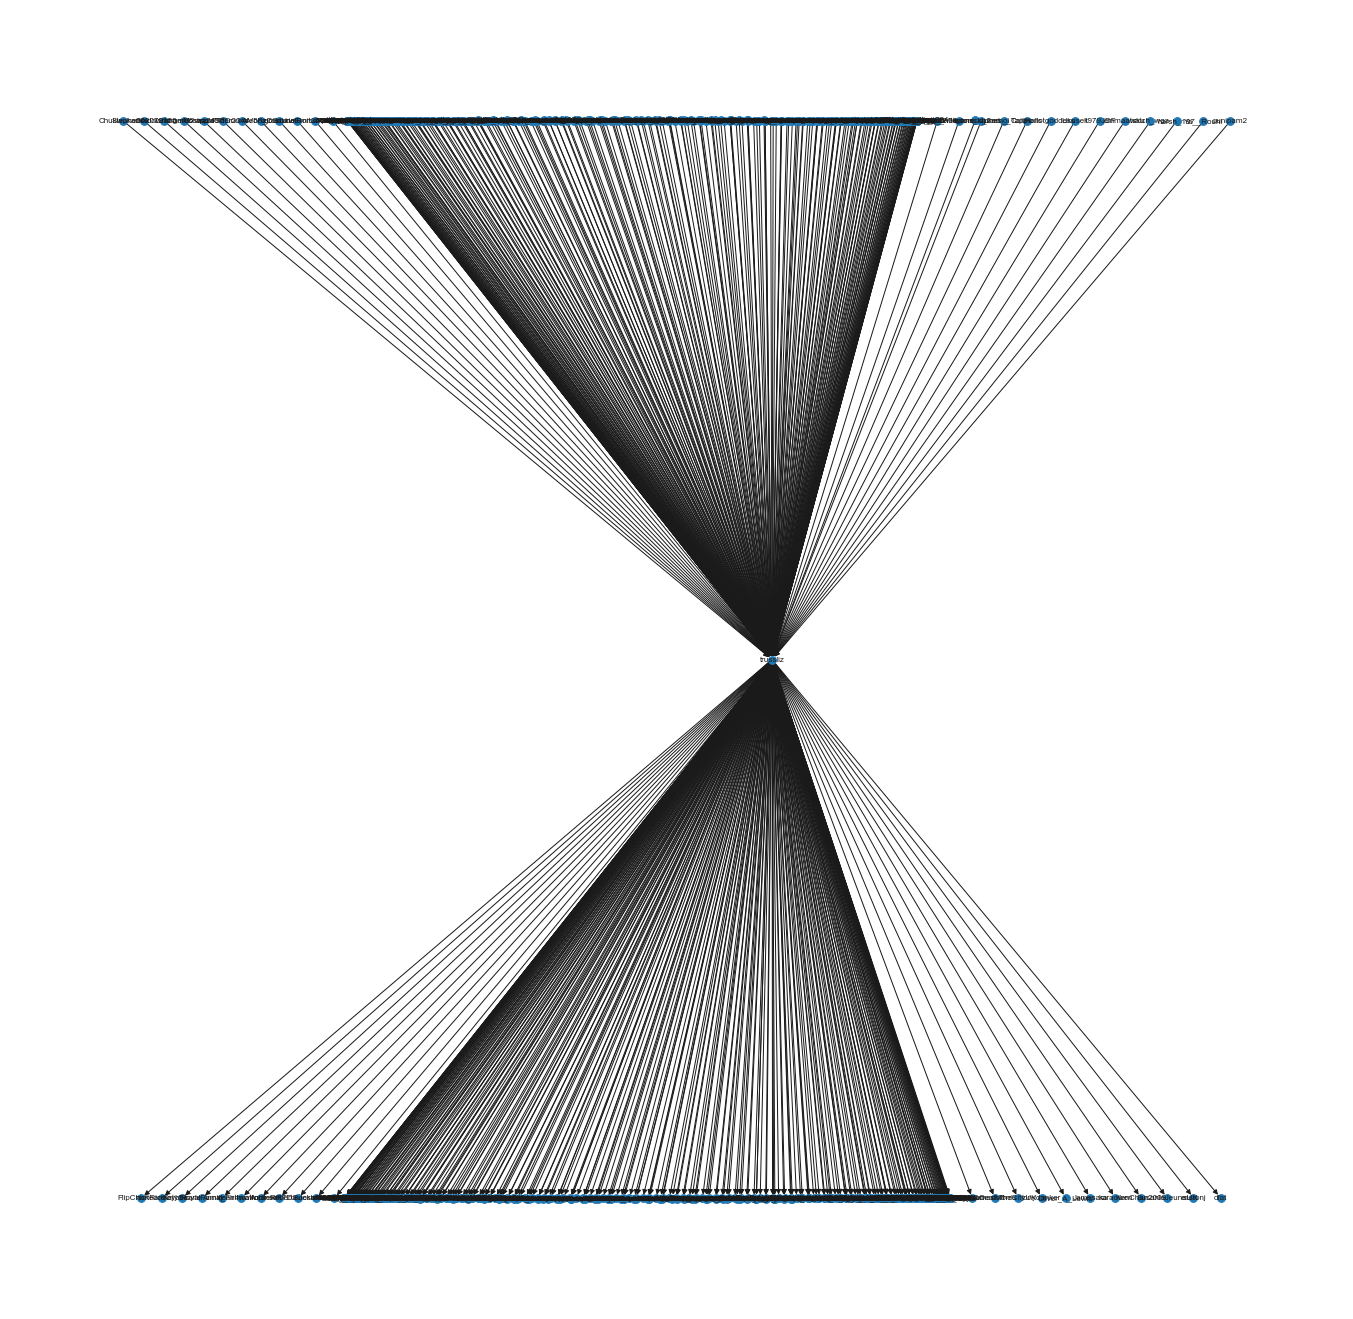

In [10]:
#
# Draw graph
#

# TODO: Remember to import matplotlib.pyplot
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle

# TODO: for you to complete!
# use networkx to draw
plt.figure(3,figsize=(24,24)) 
nx.draw_networkx(egoGraph, arrows=True, with_labels=True, pos=nx.kamada_kawai_layout(egoGraph, scale=20), node_size=60,font_size=8)
plt.axis('off')
plt.show()

In [11]:
nx.readwrite.write_graphml(egoGraph, 'follow.graphml')

The below code are for starting the sentiment and graph analysis

In [12]:
with open("COSC2671-assign1-EnergyPolicy.json", encoding="utf-8") as d:
    data = json.load(d)
data = data['data']
for index in range(0, len(data)):
    data[index]['time'] = datetime.datetime.strptime(data[index]['time'], '%Y-%m-%d %H:%M:%S%z')

tweets_df = pd.DataFrame(data)

In [13]:
data = [tweet for tweet in data if tweet['language'] == 'en']
tweets_df = tweets_df[tweets_df['language'] == 'en']

In [14]:
tweets_df.columns

Index(['id', 'text', 'time', 'hastags', 'mentions', 'language',
       'retweet count', 'like_count', 'country', 'author_id', 'username'],
      dtype='object')

In [15]:
tweets_df.shape

(2317, 11)

<AxesSubplot:xlabel='Date', ylabel='Number of Tweets'>

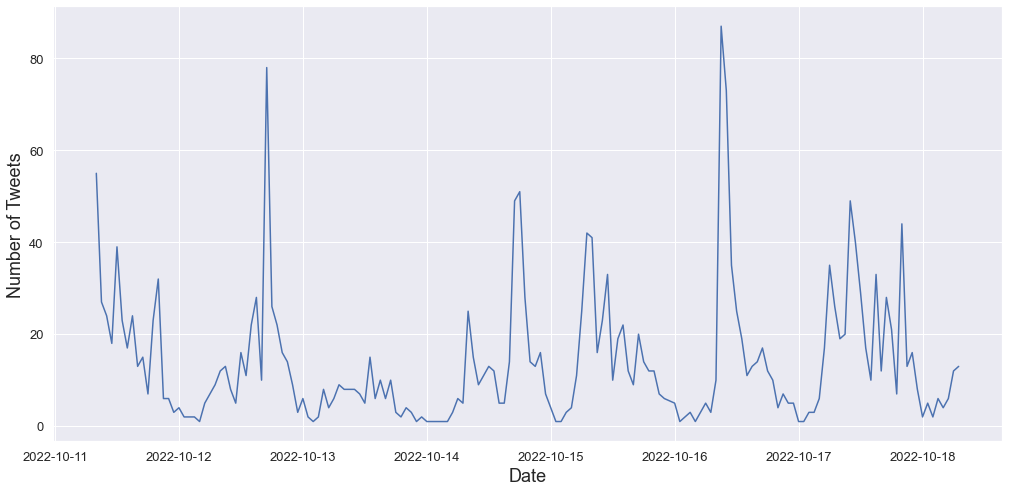

In [16]:
# Creation of separate columns for month, date and year
tweets_df.loc[:, 'month'] = tweets_df['time'].apply(lambda x: x.month)
tweets_df.loc[:, 'day'] = tweets_df['time'].apply(lambda x: x.day)
tweets_df.loc[:, 'hour'] = tweets_df['time'].apply(lambda x: x.hour)

# Dataframe for generating tweets per hour graph
df_for_tweets_per_hour = tweets_df[['month', 'day', 'hour','id']].groupby(['month', 'day', 'hour']).count().reset_index()
df_for_tweets_per_hour.loc[:, 'date'] = df_for_tweets_per_hour[['month', 'day', 'hour']].apply(lambda x: datetime.datetime(2022, x['month'], x['day'], x['hour']), axis = 1)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Tweets", fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
sns.lineplot(data=df_for_tweets_per_hour, x = 'date', y = 'id')

In [17]:
# This function will be procesing the tweet text.
def processTweet(text, stopwords):
    """
    Perform tokenisation, normalisation (lower case and stemming) and stopword and twitter keyword removal.

    @param text: tweet text
    @param stopwords: list of stopwords used

    @returns: a list of processed tokens
    """

    # covert all text to lower case
    text = text.lower()
    # tokenising the texts
    lTokens = TweetTokenizer().tokenize(text)
    # strip whitespaces before and after the text
    lTokens = [token.strip() for token in lTokens]
    # stem (we use set to remove duplicates)
    lStemmedTokens = set([PorterStemmer().stem(tok) for tok in lTokens])



    # remove stopwords, digits, hash and some other unnecessary words. Also, we are only considering words having length more than 3.
    return [tok for tok in lStemmedTokens if tok not in stopwords and not tok.isdigit() and len(tok) > 3 and '#' not in tok and 'https:' not in tok]

In [18]:
# Creating list of all the punctuations
lPunct = list(string.punctuation)
# Creating the list of stopwords including and punctuations and some unnecessary symbols 
stopwords = nltk.corpus.stopwords.words('english') + lPunct + ["’", "—", "rt", "…", "thi", "..", "💯", "..."]

all_tweets = []

for tweet in data:
    tokenised_tweet = processTweet(tweet["text"],stopwords=stopwords)
    all_tweets.append(tokenised_tweet)

# Creating the vocabulary from the tweet texts
vocab = list(chain.from_iterable(all_tweets))

# Finding the most commonly used 20 words.
word_freq = FreqDist(vocab)
common_words = word_freq.most_common(20)
common_words

[('energi', 1096),
 ('polici', 1054),
 ('price', 378),
 ('econom', 360),
 ('polit', 317),
 ('global', 302),
 ('brexit', 294),
 ('inflat', 288),
 ('shock', 282),
 ('covid', 278),
 ('return', 276),
 ('instabl', 275),
 ('@davidheniguk', 273),
 ('five', 273),
 ('resulti', 272),
 ('want', 243),
 ('risk', 234),
 ('happen', 230),
 ('call', 229),
 ('govt', 228)]

In [19]:
# Creating the list of mentions
all_mentions = list(chain.from_iterable([tweet['mentions'] for tweet in data if tweet['mentions']]))

mentions_freq = FreqDist(all_mentions)
common_mentions = mentions_freq.most_common(20)
common_mentions

[('davidheniguk', 273),
 ('russincheshire', 211),
 ('johnredwood', 156),
 ('fascinatorfun', 150),
 ('daddyhope', 145),
 ('capriconajane', 124),
 ('latimeralder', 59),
 ('burggrabenh', 53),
 ('leepfwd', 46),
 ('faisalislam', 34),
 ('estherk_k', 31),
 ('britishjock', 27),
 ('trussliz', 25),
 ('reuters', 24),
 ('nmrqip', 22),
 ('ukerchq', 21),
 ('gbnews', 20),
 ('charliejrome', 17),
 ('childofalba', 16),
 ('clim8resistance', 16)]

In [20]:
# load set of positive words
lPosWords = []
with open("positive-words.txt", 'r', encoding='utf-8', errors='ignore') as fPos:
    for sLine in fPos:
        lPosWords.append(sLine.strip())

setPosWords = set(lPosWords)

# load set of negative words
lNegWords = []
with open("negative-words.txt", 'r', encoding='utf-8', errors='ignore') as fNeg:
    for sLine in fNeg:
        lNegWords.append(sLine.strip())

setNegWords = set(lNegWords)

In [21]:
def vaderSentimentAnalysis():
    """
    Use Vader lexicons instead of a raw positive and negative word count.

    @param sTweetsFilename: name of input file containing a json formated tweet dump
    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param tweetProcessor: TweetProcessing object, used to pre-process each tweet.

    @returns: list of tweets, in the format of [date, sentiment]
    """

    # this is the vader sentiment analyser, part of nltk
    sentAnalyser = SentimentIntensityAnalyzer()


    lSentiment = []
    # open file and process tweets, one by one
    for tweet in data:
        try:
            tweetText = tweet.get('text', '')
            tweetDate = tweet.get('time')
            # pre-process the tweet text
            lTokens = processTweet(tweetText, stopwords=stopwords)

            # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
            # see lab sheet for what dSentimentScores holds
            dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

            # save the date and sentiment of each tweet (used for time series)
            lSentiment.append([pd.to_datetime(tweetDate), dSentimentScores['compound']])

        except KeyError as e:
            pass


    return lSentiment

In [22]:
vader_sentiment = vaderSentimentAnalysis()

In [23]:
# this block will add the sentiment score and sentiment nature to the data frame.
def return_sentiment(x):
    if x > 0:
        return "positive"
    elif x < 0:
        return "negative"
    return "neutral"

tweets_df['sentiment_score_vader'] = [score[1] for score in vader_sentiment]
tweets_df['sentiment_vader'] = tweets_df['sentiment_score_vader'].apply(return_sentiment)

In [24]:
tweets_df['sentiment_vader'].value_counts()

negative    806
neutral     789
positive    722
Name: sentiment_vader, dtype: int64

In [25]:
def countWordSentimentAnalysis():
    """
    Basic sentiment analysis.  Count the number of positive words, count the negative words, overall polarity is the
    difference in the two numbers.

    @param setPosWords: set of positive sentiment words
    @param setNegWords: set of negative sentiment words
    @param sTweetsFilename: name of input file containing a json formated tweet dump
    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param tweetProcessor: TweetProcessing object, used to pre-process each tweet.

    @returns: list of tweets, in the format of [date, sentiment]
    """


    lSentiment = []
    # open file and process tweets, one by one
    for tweet in data:
        try:
            tweetText = tweet.get('text', '')
            tweetDate = tweet.get('time')
            # pre-process the tweet text
            lTokens = processTweet(tweetText, stopwords=stopwords)
#            Reading the positive words
            posNum = len([tok for tok in lTokens if tok in setPosWords])
#            Reading the negative words.
            negNum = len([tok for tok in lTokens if tok in setNegWords])
#            Calculating the sentiment of the tweet
            sentiment = posNum - negNum

            # save the date and sentiment of each tweet (used for time series)
            lSentiment.append([pd.to_datetime(tweetDate), sentiment])

        except KeyError as e:
            pass

    return lSentiment

In [26]:
count_sentiment = countWordSentimentAnalysis()

In [27]:
def return_sentiment(x):
    if x > 0:
        return "positive"
    elif x < 0:
        return "negative"
    return "neutral"

tweets_df['sentiment_score_count'] = [score[1] for score in count_sentiment]
tweets_df['sentiment_count'] = tweets_df['sentiment_score_count'].apply(return_sentiment)

In [28]:
tweets_df['sentiment_count'].value_counts()

negative    995
neutral     881
positive    441
Name: sentiment_count, dtype: int64

In [29]:
# This block will be generating a data frame which will be showing the comparison between retweets and likes.
tweets_df[tweets_df['sentiment_score_vader'] < 0]['like_count'].sum()
dict_list = [{
    "Sentiment": "Positive",
    "Total retweets": tweets_df[tweets_df['sentiment_score_count'] > 0]['retweet count'].sum(),
    "Total likes": tweets_df[tweets_df['sentiment_score_count'] > 0]['like_count'].sum()
}, {
    "Sentiment": "Negative",
    "Total retweets": tweets_df[tweets_df['sentiment_score_count'] < 0]['retweet count'].sum(),
    "Total likes": tweets_df[tweets_df['sentiment_score_count'] < 0]['like_count'].sum()
}]
pd.DataFrame(dict_list)

,Sentiment,Total retweets,Total likes
0,Positive,28807,1587
1,Negative,154479,4731


In [30]:
# Creation of data frame for plotting the sentiments across time.
df_for_time_series = tweets_df.drop(['id', 'retweet count', 'like_count'], axis = 1).groupby(['month', 'day', 'hour']).sum().reset_index()
df_for_time_series['date'] = df_for_time_series[['month', 'day', 'hour']].apply(lambda x: datetime.datetime(2022, x['month'], x['day'], x['hour']), axis = 1)

<AxesSubplot:xlabel='Date', ylabel='Count sentiment score'>

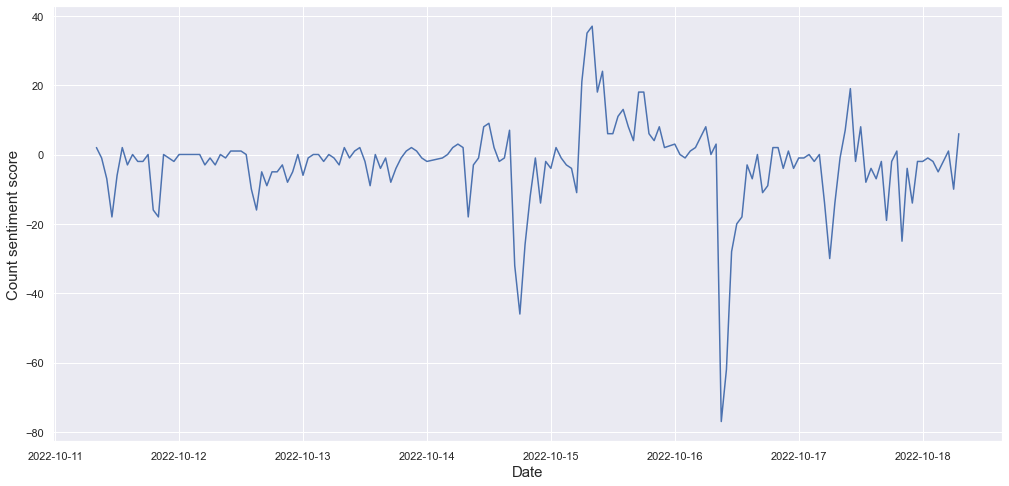

In [31]:
# Plotting the sentiment across time
plt.xlabel("Date", fontsize = 15)
plt.ylabel("Count sentiment score", fontsize = 15)
sns.lineplot(data = df_for_time_series, x = 'date', y = 'sentiment_score_count')

The graph construction starts from below

In [32]:
energyGraph = nx.Graph()

In [33]:
pos_data = tweets_df[(tweets_df['sentiment_count'] ==  'positive') & (tweets_df['retweet count'] > 20)][['username', 'sentiment_score_count', 'author_id', 'retweet count', 'id']]
pos_data.head()

,username,sentiment_score_count,author_id,retweet count,id
5,sgibs68,1,3063301217,30,1582275649133125632
137,Rax230,2,1201070004,165,1582084896842883072
141,WeeW151071,1,1507408487608983555,30,1582079209643855877
151,margatesunsets,2,618647631,165,1582072637710221312
152,TomSyvret,2,1256987273217953794,165,1582072168871256064


In [34]:
neg_data = tweets_df[(tweets_df['sentiment_count'] ==  'negative') & (tweets_df['retweet count'] > 20)][['username', 'sentiment_score_count', 'author_id', 'retweet count', 'id']]
neg_data.head()

,username,sentiment_score_count,author_id,retweet count,id
9,nmrqip,-3,310966663,22,1582271264273506304
16,dav_bon,-1,621394407,49,1582256595060527105
18,no2_netzero,-1,1580198396425560064,49,1582255659785261056
20,RodWaterer,-1,1465555358491889668,49,1582252538484490242
22,Urban_Nanna,-1,28305484,49,1582251258789867521


In [35]:
for i in pos_data.itertuples():
    energyGraph.add_node(i[1], score = i[2], retweets = i[4])
    for j in range(i[4]):
        energyGraph.add_node(f'{i[5]}_{j}', nature = 'pos')
        energyGraph.add_edge(i[1], f'{i[5]}_{j}')

In [53]:
users_li = []
for item in pos_data['id']:
    try:
        resp = client.get_retweeters(item)
        if "data" in resp:
            for user in resp.data:
                users_li.append(user.username)
                energyGraph.add_node(f'{user.username}', nature = 'pos')
                energyGraph.add_edge(item, user.username)
    except:
        print("TooManyRequests")

In [54]:
for item in users_li:
    try:
        resp = client.get_users_followers(item)
        if "data" in resp:
            for user in resp.data:
                energyGraph.add_node(f'{user.username}', nature = 'pos')
                energyGraph.add_edge(item, user.username)
    except:
        print("TooManyRequests")

In [36]:
len(energyGraph.edges())

31640

In [307]:
energyGraph.add_node('liztruss')

In [37]:
with open('Graphs/EnergyPolicyPos.graphml', 'wb') as fOut:
    nx.write_graphml(energyGraph, fOut)

In [28]:
for i in neg_data.itertuples():
    energyGraph.add_node(i[1], score = i[2], retweets = i[4])
    for j in range(i[4]):
        energyGraph.add_node(f'{i[5]}_{j}', nature = 'neg')
        energyGraph.add_edge(i[1], f'{i[5]}_{j}')

In [ ]:
for item in pos_data['id']:
    resp = client.get_retweeters(id=item)
    for user in resp.data:
         energyGraph.add_node(f'{user.username}', nature = 'pos')
         energyGraph.add_edge(item, user.username)

In [37]:
with open('Graphs/EnergyPolicyNeg.graphml', 'wb') as fOut:
    nx.write_graphml(energyGraph, fOut)

In [455]:
with open("Followers_liztruss.json") as truss:
    follow_liz = json.load(truss)

follow_liz = [i['id'] for i in follow_liz['data']]